# Lending Club - model klasyfikacyjny, przewidujący spłacenie pożyczki 
#### Projekt końcowy Machine Learning Helena Sokołowska

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
import processing # importuję plik z funkcjami w pythonie

In [3]:
# wyłączam ostrzeżenia
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
df=pd.read_csv("Loan_data.csv")

C:\Users\Hela\AppData\Local\Temp\ipykernel_10372\481423048.py:1: DtypeWarning: Columns (0,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Loan_data.csv")


In [5]:
df.shape
# mamy 151 kolumn i 42536 obserwacji

(42536, 151)

## 1. Obróbka danych

#### Usuwanie niepotrzebnych kolumn

In [6]:
# wyrzucanie kolumn z dużym odsetkiem brakujących wartości - dokładnie wyższym niż 60%
thresh = len(df) * 0.6
df = df.dropna(thresh = thresh, axis = 1)
df.shape

(42536, 60)

In [7]:
# usuwam kolumny z informacjami, które nie będą przydatne w analizie: opisowe, takie, które są dla
# każdej obserwacji inne
df = df.drop(columns = ['id','url','title','emp_title', 'desc'])

# z tego mogłabym wyciągnąć jakieś informacje, może powtarzające się firmy, może z firm wyciągnąć branże
# generalnie to nie musi, ale może mieć jakiś wpływ

In [8]:
# zip_code
len(list(df['zip_code'].unique()))

838

In [9]:
# addr_state
len(list(df['addr_state'].unique()))

51

Zmienne zip_code i addr_state są zmiennymi tekstowymi, kategorycznymi o zbyt wielu wartościach, aby mogły być użyteczne w analizie. Zstawienie tak wielu wartości nienumerycznych może sprzyjać przeuczeniu modelu. Jednocześnie cięzko zrekodować te zmienne na takie o niewielkiej liczbie wartości ze względu na brak jednoznacznego klucza.
Dodatkowo adres zamieszkania nie powinien wpływać na badane zjawisko, zatem te zmienne również decyduję się usunąć.

In [10]:
df = df.drop(columns = ['zip_code', 'addr_state'])

Identyfikuję zmienne, które zawierają dane niedostępne w momencie składania wniosku o pożyczkę - takie jak płatności otrzymane do tej pory, opóźnienia, informacje po sfinansowaniu pożyczki.

- 'total_pymnt' - płatności otrzymane do tej pory
- 'total_pymnt_inv', - płatności otrzymane do tej pory - frakcja pochodząca od inwestorów
- 'total_rec_prncp', - otrzymane płatności od kwoty głównej
- 'total_rec_int', - otrzymane płatności od odsetek
- 'total_rec_late_fee', - opóźnione opłaty
- 'last_pymnt_d', - data ostatniej płatności
- 'last_pymnt_amnt', - kwota ostatniej płatności
- 'last_credit_pull_d', - osatni miesiąc, w którym LC wziął kredyt na tę pożyczkę
- 'last_fico_range_high', - najnowsze FICO score pożyczkobiorcy - dolny próg (FICO score zmienia się w czasie i banki regularnie aktualizują w swoich bazach informacje na jego temat)
- 'last_fico_range_low', - j.w. - górny próg

Czyli jak widać po opisach, są to informacje dotyczące już udzielonej pożyczki i jej procesowania, a zatem nie możemy użyć ich do modelu, który ma dokonać przewidywań w momencie złożenia wniosku przez klienta.

- 'issue_d' - miesiąc, w którym pożyczka została sfinansowana

Ta ostatnia zmienna również jest daną, której nie mamy w momencie otrzymania wniosku, jednak nie mamy w zbiorze informacji o dacie wpłynięcia wniosku, a data sfinansowania pożyczki jest jej najbliższą aproksymacją, w związku z tym zostawiam zmienną w zbiorze.

In [11]:
# usuwam kolumny z informacjami z przyszłości na podstawie ich opisów
df = df.drop(columns = ['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                            'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high',
                           'last_fico_range_low'])


array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'annual_inc'}>],
       [<AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'fico_range_low'}>,
        <AxesSubplot:title={'center':'fico_range_high'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>],
       [<AxesSubplot:title={'center':'open_acc'}>,
        <AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp'}>],
       [<AxesSubplot:title={'center':'out_prncp_inv'}>,
        <AxesSubplot:title={'center':'recoveries'}>,
        <AxesSubplot:title={'center':'collection_recovery_fee'}>,
        <AxesSubplot:t

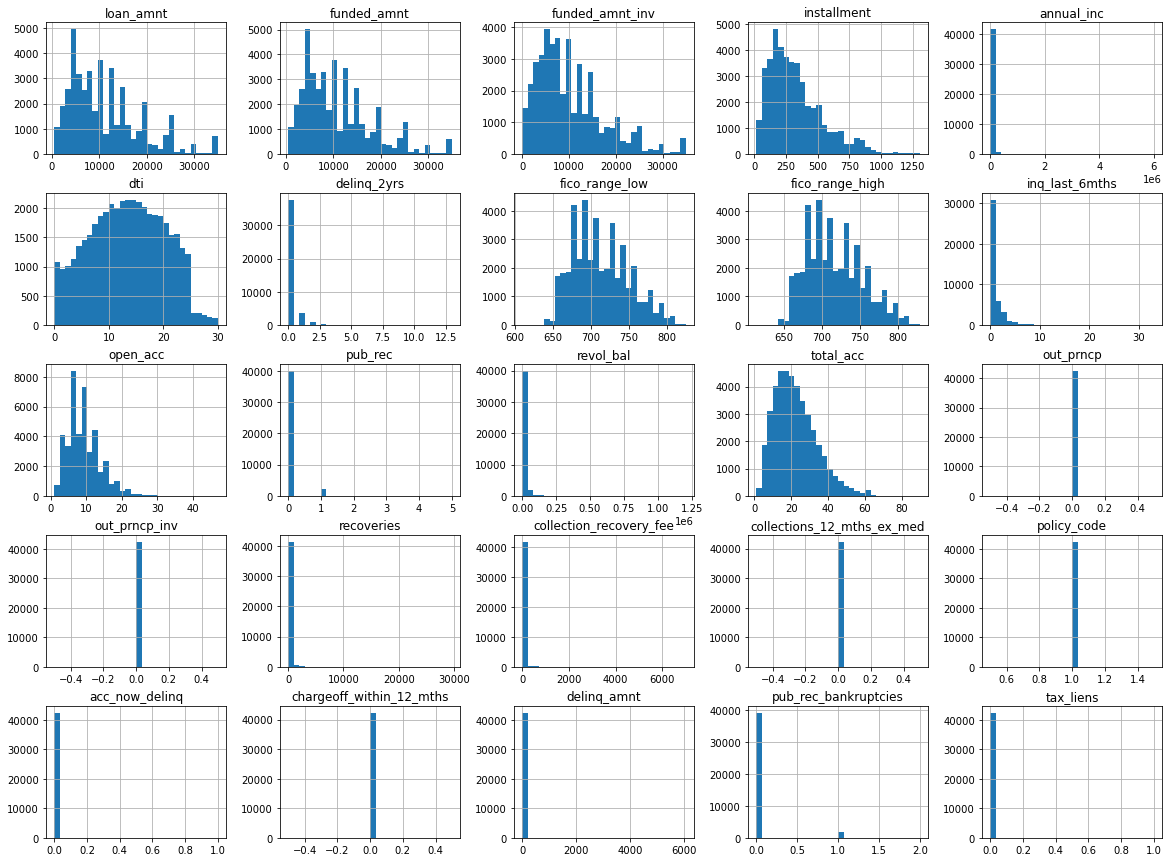

In [12]:
# patrzę na histogramy zmiennych, żeby wyłapać, czy jeszcze któreś z nich mają 90%+ jednej wartości
df.hist(bins=30, figsize=(20, 15))

In [13]:
# wybieram te zmienne, których histogramy wydają się składać głównie z jednej wartości i sprawdzam ich rozkłady
col_list = ['annual_inc','delinq_2yrs','inq_last_6mths','pub_rec','revol_bal','recoveries',
            'collection_recovery_fee','collections_12_mths_ex_med','acc_now_delinq',
            'chargeoff_within_12_mths','delinq_amnt','pub_rec_bankruptcies','tax_liens']
processing.print_sorted_values(df, col_list)

annual_inc 
 17568.0     0.002351
112455.0    0.002351
48750.0     0.002351
58179.0     0.002351
105859.0    0.002351
              ...   
30000.0     2.078484
45000.0     2.111401
40000.0     2.198396
50000.0     2.631022
60000.0     3.740801
Name: annual_inc, Length: 5597, dtype: float64 


delinq_2yrs 
 9.0      0.002353
13.0     0.002353
11.0     0.004705
8.0      0.007058
7.0      0.014116
6.0      0.030584
5.0      0.063520
4.0      0.169388
3.0      0.574037
2.0      1.813862
1.0      8.457630
0.0     88.860396
Name: delinq_2yrs, dtype: float64 


inq_last_6mths 
 20.0     0.002353
25.0     0.002353
28.0     0.002353
31.0     0.002353
33.0     0.002353
32.0     0.002353
27.0     0.002353
19.0     0.004705
24.0     0.004705
17.0     0.004705
16.0     0.007058
18.0     0.009410
14.0     0.014116
13.0     0.014116
15.0     0.021173
11.0     0.035289
12.0     0.035289
10.0     0.056463
9.0      0.117630
8.0      0.270550
7.0      0.428175
6.0      0.797534
5.0      1.402155
4.0     

In [14]:
# usuwam te zmienne, które mają 99%+ jednej wartości, a także zmienne pub_rec (94% zer i 5% jedynek)
# oraz pub_rec_bankruptcies (92% zero, 4% jedynek i reszta missingi) - te zmienne również nie dadzą nam wiele informacji

df = df.drop(columns = ['collections_12_mths_ex_med', 'acc_now_delinq',
                           'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'pub_rec', 'pub_rec_bankruptcies'])
df.shape

(42536, 36)

Na histogramach nie mogłam przedstawić zmiennych kategorycznych, więc zanalizuję je osobno.

In [15]:
object_column_list = df.select_dtypes(include='object').columns.tolist()
processing.print_sorted_values(df, object_column_list)

term 
  60 months    25.863407
 36 months    74.136593
Name: term, dtype: float64 


int_rate 
  16.20%    0.002351
 17.72%    0.002351
 17.41%    0.002351
 17.44%    0.002351
 24.59%    0.002351
             ...   
  7.88%    1.744446
  7.51%    1.850241
 13.49%    1.956036
 11.49%    1.967791
 10.99%    2.280475
Name: int_rate, Length: 394, dtype: float64 


grade 
 G     1.203715
F     3.058658
E     7.979311
D    14.143646
C    20.547784
A    23.940284
B    29.126602
Name: grade, dtype: float64 


sub_grade 
 G3    0.185729
G5    0.202186
G4    0.232750
G2    0.251558
G1    0.331492
F5    0.362055
F4    0.496062
F3    0.554837
F2    0.724110
F1    0.921594
E5    1.173152
E4    1.297755
E3    1.570471
E2    1.859645
E1    2.078288
D5    2.388621
D1    2.475608
D4    2.680146
A1    2.684848
C5    3.035148
D3    3.108029
C4    3.220877
D2    3.491243
A2    3.573528
C3    3.897966
A3    4.285882
B1    4.424592
B2    4.967674
C2    5.071118
C1    5.322675
B4    6.089103
A5    6.566357
B

In [16]:
# te zmienne również mają tylko jedną wartość lub 99% jednej wartości
df = df.drop(columns = ['initial_list_status', 'application_type', 'pymnt_plan',
                           'hardship_flag', 'disbursement_method', 'debt_settlement_flag'])
df.shape

(42536, 30)

#### Usuwanie niepotrzebnych obserwacji

In [17]:
# usuwam puste wiersze
df = df.dropna(axis = 0, how = 'all')
df.shape

(42535, 30)

In [18]:
# usuwam obserwacje, w których jest większość pustych wartości
perc = 75.0 # próg
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna( axis=0, thresh=min_count)
df.shape # nie było takich wierszy

(42535, 30)

In [19]:
# usuwam obserwacje, których nie chcemy brać pod uwagę
# loan_status (to nasza zmienna objaśniana)
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

Zmienna przyjmuje wartości zawierające informacje, że dana obserwacja nie spełnia polityki kredytowej banku. Wyrzucam te obserwacje, ponieważ nie chcę uczyć modelu na danych, które nie są zgodne z wytycznymi i prawdopodobnie nie są korzystne dla biznesu.

In [20]:
df = df[(df['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid') & 
           (df['loan_status'] != 'Does not meet the credit policy. Status:Charged Off')]
df.shape

(39786, 30)

Po usunięciu niepotrzebnych obserwacji ponownie sprawdzam, czy mam jakieś kolumny z pojedynczymi wartościami i usuwam je

In [21]:
df = processing.drop_constant_columns(df)
df.shape

(39786, 27)

#### Rekodowanie zmiennych

In [22]:
# usuwam słowa z niektórych zmiennych, np. months, years, %
col_list = ['revol_util','int_rate', 'term']
for col in col_list:
    df[col] = df[col].str.replace(r'\D', '', regex = True)
    df[col] = pd.to_numeric(df[col])

df.loc[:,['int_rate', 'term', 'revol_util']].head()

,int_rate,term,revol_util
0,1065,36,837.0
1,1527,60,94.0
2,1596,36,985.0
3,1349,36,21.0
4,1269,60,539.0


In [23]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [24]:
# zmienna emp_length - tutaj trzeba pozamieniać <1 year na 0 najpierw
df['emp_length'] = df['emp_length'].replace('< 1 year', '0')
df['emp_length'] = df['emp_length'].str.replace(r'\D', '', regex = True)
df['emp_length'] = pd.to_numeric(df['emp_length'])
df['emp_length'].head()

0    10.0
1     0.0
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

#### Uzupełnianie brakujących wartości 

In [25]:
# sprawdzam ile brakujących wartości jest w pozostałych zmiennych
missing_values_series = df.isna().sum()
missing_values_series = missing_values_series[missing_values_series>0] 
print(round(100*(missing_values_series/len(df.index)), 2)) # wyświetl wartości w procentach

emp_length    2.71
revol_util    0.13
dtype: float64


Brakujące wartości znajdują się w zmiennch ilościowych, więc uzupełnię je
średnimi w podgrupach wyodrębnionych na podstawie 2 zmiennych opisujących klientów:
- dochód roczny - annual_inc
- punktacja FICO - fico_range_low

Tworzę nową zmienną, aby podzielić zbiór na podgrupy według deklarowanego dochodu:

In [27]:
processing.create_10_categories(df, 'annual_inc', 'annual_inc_cat_10')
df['annual_inc_cat_10'].head()

0    1
1    2
2    1
3    4
4    8
Name: annual_inc_cat_10, dtype: int64

Tworzę następną zmienną, aby analogicznie podzielić zbiór według deklarowanego dochodu.
Przy tym korzystam z załączonego dokumentu z informacją o przyjmowanym podziale na kategorie kredytobiorców według otrzymanej punktacji FICO

In [28]:
def map_fico(score):
  if score < 580:
    return "1. Poor"
  elif 580 <= score < 670:
    return "2. Fair"
  elif 670 <= score < 740:
    return "3. Good"
  elif 740 <= score < 800:
    return "4. Very Good"
  else:
    return "5. Exceptional"
df["fico_range_low_cat"] = df["fico_range_low"].apply(lambda score: map_fico(score))

In [29]:
# uzupełniam brakujące wartości na podstawie dochodu kategoryzowanego i FICO kategoryzowanego
df[['emp_length', 'revol_util']] = df.groupby(['annual_inc_cat_10', 'fico_range_low_cat'])[['emp_length', 'revol_util']]\
                        .transform(lambda x: x.fillna(round(x.mean())))

In [30]:
df.to_csv('Loan_data_after_processing.csv', index=False)